In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import util
import os
os.environ['R_HOME'] = "/usr/share/anaconda3/lib/R"

%matplotlib inline

In [2]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
r_utils = importr('utils')

In [3]:
data = pd.read_csv('data/all_data.csv')

In [4]:
data.columns

Index(['Unnamed: 0', 'Youtube_Hotness', 'Unnamed: 0.1', 'artist.hotttnesss',
       'artist.id', 'artist.name', 'artist_mbtags', 'artist_mbtags_count',
       'bars_confidence', 'bars_start',
       ...
       'title_compound.1', 'release.name_neg.1', 'release.name_neu.1',
       'release.name_pos.1', 'release.name_compound.1', 'artist_freq.1',
       'country', 'country_foreign', 'country_unknown', 'country_us'],
      dtype='object', length=148)

In [5]:
data.groupby('country').size()

country
foreign    2012
unknown    4295
us         3693
dtype: int64

In [9]:
import pymc3 as pm

In [10]:
data.columns

Index(['artist.hotttnesss', 'artist.id', 'artist.name', 'artist_mbtags',
       'artist_mbtags_count', 'bars_confidence', 'bars_start',
       'beats_confidence', 'beats_start', 'duration', 'end_of_fade_in',
       'familiarity', 'key', 'key_confidence', 'latitude', 'location',
       'longitude', 'loudness', 'mode', 'mode_confidence', 'release.id',
       'release.name', 'similar', 'song.hotttnesss', 'song.id',
       'start_of_fade_out', 'tatums_confidence', 'tatums_start', 'tempo',
       'terms', 'terms_freq', 'time_signature', 'time_signature_confidence',
       'title', 'year', 'decade', 'artist_firstname', 'artist_lastname',
       'mbtags_count', 'mbtag_0', 'mbtag_1', 'mbtag_2', 'similar_hotness',
       'term_id', 'hotness', 'title_neg', 'title_neu', 'title_pos',
       'title_compound', 'release.name_neg', 'release.name_neu',
       'release.name_pos', 'release.name_compound', 'country'],
      dtype='object')

In [21]:
sub_data = data[['artist.hotttnesss','loudness','time_signature','country']]
n_var = len(sub_data.columns)

In [22]:
X_train, X_test, y_train, y_test=train_test_split(sub_data,data['hotness'],test_size = 0.4,random_state =42)

In [24]:
c_train=[0 if i=='unknown' else 1 if i=='foreign' else 2 for i in X_train['country']]
X_train =X_train.drop(columns = ['country'])
#sub_data['country']=c

In [14]:
import theano
import theano.tensor as tt

In [38]:
with pm.Model() as pooled_model: 
    # number of predictors 
    n_var = len(X_train.columns)
    # common prior for intercept
    mu = pm.Normal('mu',0,sd = 5)
    std = pm.HalfCauchy('sd',5)
    intercept = pm.Normal('intercept',mu,std,shape = 3)
    param_matrix = pm.Normal('param', 0, sd = 50, shape = (3,n_var))
    colname = X_train.columns
    eps = pm.HalfCauchy('eps', 2,shape = 3)
    hotness = intercept[c_train]
    for idx in range(n_var):
        hotness += param_matrix[c_train,idx]*X_train[colname[idx]].values
    noise = pm.Deterministic('sample noise',eps[c_train])
    y = pm.Normal('y', hotness, sd = noise, observed = y_train.values)

/usr/share/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [39]:
with pooled_model:
    trace = pm.sample(100,n_jobs=4)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/share/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, param, intercept, sd, mu]
Sampling 2 chains: 100%|██████████| 1200/1200 [01:21<00:00, 14.19draws/s]


In [40]:
pps = pm.sample_ppc(trace, model = pooled_model)

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
  0%|          | 0/200 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Refreshing lock /jupyteruser/71352838/.theano/compiledir_Linux-4.4--aws-x86_64-with-debian-stretch-sid-x86_64-3.6.8-64/lock_dir/lock
/usr/share/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 200/200 [00:01<00:00, 183.50it/s]


In [41]:
pred_train = np.mean(pps['y'],axis=0)

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
mse = mean_squared_error(pred_train,y_train.values)
print('train mse',mse)

train mse 78.55851860424968


In [49]:
intercept = np.mean(trace['intercept'],axis = 0)
param = np.mean(trace['param'],axis = 0)

In [46]:
c_test=[0 if i=='unknown' else 1 if i=='foreign' else 2 for i in X_test['country']]
X_test['country'] = c_test

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [65]:
colname = X_train.columns
colname

Index(['artist.hotttnesss', 'loudness', 'time_signature'], dtype='object')

In [89]:
pred_test = []
for i in range(len(X_test)):
    a = intercept[X_test['country'].values[i]]
    result =  a+np.sum(X_test.iloc[i][colname].values*param[X_test['country'].values[i]])
    pred_test.append(result)

In [91]:
mse = mean_squared_error(pred_test,y_test.values)
print('test mse',mse)

tesr mse 80.31288917876697


In [92]:
# graph
cutoff=int(trace['param'].shape[0]/2)

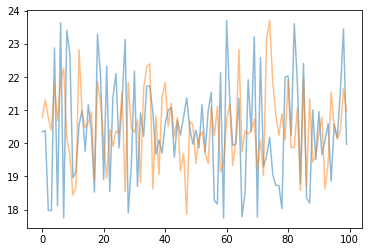

In [93]:
plt.plot(trace['param'][:cutoff,0,0],alpha = 0.5);
plt.plot(trace['param'][cutoff:,0,0],alpha = 0.5);

In [96]:
df = pd.DataFrame(np.mean(trace['param'],axis = 0),
             columns = ['artist.hotttnesss', 'loudness', 'time_signature'],
             index = ['country-unknown','country-foreign','country-us'])
df['intercept'] = intercept

In [97]:
df

,artist.hotttnesss,loudness,time_signature,intercept
country-unknown,20.443752,0.204075,0.213834,-2.454934
country-foreign,24.850144,0.236238,0.145136,-3.008440
country-us,17.437727,0.141364,0.137667,0.275601


We see that even after pooling 3 different types of country, the intercept and loudness ara significantly different across countries. This analysis tells us it is essential to control for region-related factor in order to eliminate heteogeneity. We cannot see clearly the selection bias. To see this we need another model.

In [99]:
with pm.Model() as unpooled_model:   
    # number of predictors 
    n_var = len(X_train.columns)
    # common prior for intercept
    intercept = pm.Normal('intercept',0,10,shape = 3)
    param_matrix = pm.Normal('param', 0, sd = 50, shape = (n_var))
    colname = X_train.columns
    eps = pm.HalfCauchy('eps', 2,shape = 3)
    hotness = intercept[c_train]
    for idx in range(n_var):
        hotness += param_matrix[idx]*X_train[colname[idx]].values
    noise = pm.Deterministic('sample noise',eps[c_train])
    y = pm.Normal('y', hotness, sd = noise, observed = y_train.values)

In [100]:
with unpooled_model:
    unpooled_trace = pm.sample(200,n_jobs=2)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, param, intercept]
Sampling 2 chains: 100%|██████████| 1400/1400 [00:15<00:00, 91.08draws/s] 


In [109]:
np.mean(unpooled_trace['param'],axis = 0)

array([19.83736785,  0.18199046,  0.16776702])

In [110]:
np.mean(unpooled_trace['intercept'],axis = 0)

array([-2.32470009, -1.54129948, -0.40597227])

In [112]:
pps = pm.sample_ppc(unpooled_trace, model = unpooled_model)
pred_train = np.mean(pps['y'],axis=0)

/usr/share/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 400/400 [00:00<00:00, 462.17it/s]


In [113]:
mse = mean_squared_error(pred_train,y_train.values)
print('train mse',mse)

train mse 78.65201830962555


In [114]:
intercept = np.mean(unpooled_trace['intercept'],axis = 0)
param=np.mean(unpooled_trace['param'],axis = 0)
pred_test = []
for i in range(len(X_test)):
    a = intercept[X_test['country'].values[i]]
    result =  a+np.sum(X_test.iloc[i][colname].values*param)
    pred_test.append(result)

In [115]:
mse = mean_squared_error(pred_test,y_test.values)
print('test mse',mse)

test mse 80.46331267821131


### F-testing

In [6]:
dropcol = ['artist.id', 'artist.name','artist_mbtags',
           'artist_mbtags_count',
           'song.id','familiarity',
           'longitude','release.name','song.hotttnesss',
           'artist.id','year','release.id','terms', 'terms_freq',
            'title','location','term_id','latitude','mbtags_count',
           'country','similar','Unnamed: 0'
          ]
confidence = ['bars_confidence','mode_confidence',
              'tatums_confidence','time_signature_confidence',
              'beats_confidence','key_confidence'
             ]
engineered = ['release.name_neu','release.name_pos','release.name_neg',
             'title_neg','title_neu', 'title_pos',
              'mbtag_0', 'mbtag_1', 'mbtag_2','artist_firstname', 
              'artist_lastname','title_compound',
              'release.name_compound','similar_hotness']
augmented = ['artist_freq']

In [7]:
list(set(data.columns)-set(dropcol)-set(confidence)-set(augmented))

['title_svd_3_10.1',
 'song.id.1',
 'time_signature.1',
 'duration',
 'loudness',
 'key',
 'start_of_fade_out',
 'title_svd_4_10',
 'title_neg',
 'beats_start',
 'artist.id.1',
 'title_svd_5_10',
 'mode',
 'release_svd_2_10',
 'release_svd_6_10',
 'song.hotttnesss.1',
 'title_svd_6_10.1',
 'country_us',
 'longitude.1',
 'latitude.1',
 'y_fit_term',
 'terms.1',
 'release.name_pos',
 'mbtag_2',
 'end_of_fade_in.1',
 'release_svd_8_10',
 'title_svd_1_10',
 'year.1',
 'tatums_start.1',
 'title_svd_1_10.1',
 'mbtags_count.1',
 'release.name_neu.1',
 'tempo',
 'title_svd_8_10',
 'title_svd_10_10.1',
 'release.name_compound',
 'release_svd_1_10',
 'release.name_neg.1',
 'title_svd_10_10',
 'mode_confidence.1',
 'release_svd_3_10',
 'bars_confidence.1',
 'country_foreign',
 'title_svd_2_10',
 'term_id.1',
 'artist_mbtags_count.1',
 'artist.hotttnesss.1',
 'tatums_start',
 'title_svd_9_10.1',
 'mbtag_1.1',
 'beats_start.1',
 'release.name_neu',
 'release.id.1',
 'artist_firstname.1',
 'hotness'

In [8]:
# drop similar hotness because it has 7684 rows
# 'mbtag_1','mbtag_2','mbtag_0' have too many levels(several hundreds) to we drop for now
dict_data = {}
quant = ['mode','tatums_start','release.name_compound',
 'loudness','bars_start','title_compound','artist.hotttnesss',
 'beats_start','start_of_fade_out',
 'key','tempo','duration','end_of_fade_in','time_signature']
cat = ['decade','artist_lastname','title_pos',
      'artist_firstname','release.name_neu','release.name_pos',
 'title_neg','release.name_neg','title_neu', 'country']
for col in quant:
    dict_data[col] = rpy2.robjects.FloatVector(data[col].values)
for col in cat:
    dict_data[col] = rpy2.robjects.vectors.StrVector(data[col].values)
dict_data['response'] = rpy2.robjects.FloatVector(data['hotness'].values)
r_data_engineered = rpy2.robjects.DataFrame(dict_data)

In [9]:
data['similar_hotness'].isna().sum()

7684

In [12]:
dict_data = {}
quant = ['artist.hotttnesss', 'bars_start', 'beats_start', 'duration',
       'end_of_fade_in', 'key', 'loudness', 'mode', 
       'start_of_fade_out', 'tatums_start', 'tempo', 'time_signature',
        'artist_freq','grammy_relevance']
cat = ['decade','country']
for col in quant:
    dict_data[col] = rpy2.robjects.FloatVector(data[col].values)
for col in cat:
    dict_data[col] = rpy2.robjects.vectors.StrVector(data[col].values)
dict_data['response'] = rpy2.robjects.FloatVector(data['hotness'].values)
r_data_augmented = rpy2.robjects.DataFrame(dict_data)

In [13]:
dict_data = {}
quant = ['artist.hotttnesss', 'bars_start', 'beats_start', 'duration',
       'end_of_fade_in', 'key', 'loudness', 'mode', 
       'start_of_fade_out', 'tatums_start', 'tempo', 'time_signature']
cat = ['decade','country']
for col in quant:
    dict_data[col] = rpy2.robjects.FloatVector(data[col].values)
for col in cat:
    dict_data[col] = rpy2.robjects.vectors.StrVector(data[col].values)
dict_data['response'] = rpy2.robjects.FloatVector(data['hotness'].values)
r_data = rpy2.robjects.DataFrame(dict_data)

In [14]:
%reload_ext rpy2.ipython

In [15]:
%%R -i r_data -i r_data_augmented -i r_data_engineered
null_model = lm(response~.,data= r_data)
augmented_model = lm(response~.,data=r_data_augmented)
engineered_model = lm(response~.,data = r_data_engineered)
print('augmented vs baseline')
anova(null_model, augmented_model, test="Chisq")

/usr/share/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[1] "augmented vs baseline"
Analysis of Variance Table

Model 1: response ~ artist.hotttnesss + bars_start + beats_start + duration + 
    end_of_fade_in + key + loudness + mode + start_of_fade_out + 
    tatums_start + tempo + time_signature + decade + country
Model 2: response ~ artist.hotttnesss + bars_start + beats_start + duration + 
    end_of_fade_in + key + loudness + mode + start_of_fade_out + 
    tatums_start + tempo + time_signature + artist_freq + grammy_relevance + 
    decade + country
  Res.Df    RSS Df Sum of Sq  Pr(>Chi)    
1   9975 771167                           
2   9973 768274  2    2892.7 7.016e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
%%R -i r_data -i r_data_engineered
c = which(is.na(r_data_engineered), arr.ind=TRUE)[1]
r_data = r_data[-c,]
r_data_engineered = r_data_engineered[-c,]
null_model = lm(response~.,data= r_data)
engineered_model = lm(response~.,data = r_data_engineered)
anova(null_model, engineered_model, test="Chisq")

Analysis of Variance Table

Model 1: response ~ artist.hotttnesss + bars_start + beats_start + duration + 
    end_of_fade_in + key + loudness + mode + start_of_fade_out + 
    tatums_start + tempo + time_signature + decade + country
Model 2: response ~ mode + tatums_start + release.name_compound + loudness + 
    bars_start + title_compound + artist.hotttnesss + beats_start + 
    start_of_fade_out + key + tempo + duration + end_of_fade_in + 
    time_signature + decade + artist_lastname + title_pos + artist_firstname + 
    release.name_neu + release.name_pos + title_neg + release.name_neg + 
    title_neu + country
  Res.Df    RSS   Df Sum of Sq Pr(>Chi)   
1   9974 770927                           
2   8796 670978 1178     99949 0.004114 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
